# True Fixed Polynomial Regression with SGD

This notebook evaluates convergence behavior and generalization performance of SGD on synthetic polynomial data with fixed coefficients. We compare our three stepsize strategies — fixed, halving, and diminishing — using both training and test error. Here, we aim to assess how SGD performs when the model matches the true data-generating process as well as overfitting and underfitting with different degrees.


In [ ]:
import sys
sys.path.append("..") 

import numpy as np
import matplotlib.pyplot as plt
from src.sgd.sgd import SGD
from src.utils.parameter_estimator import ParameterEstimator
from src.models.regression_model import RegressionModel
from src.data.generate_synthetic_data import generate_training_data_fixed, transform_to_polynomial
from sklearn.model_selection import train_test_split

### Summary of Train/Test Error Over 20 Runs

We generate new synthetic data each time and report mean ± std of final losses.

In [4]:
X_raw, _, _ = generate_training_data_fixed(m=5000, n=2, noise=0.01)
true_degree = 2
X_true_poly = transform_to_polynomial(X_raw, degree=true_degree, normalize=False)

true_A = 0.1 * np.arange(1, X_true_poly.shape[1] + 1)
true_b = 1.0
noise = 0.01
y = X_true_poly @ true_A + true_b + np.random.normal(0, noise, size=X_true_poly.shape[0])

train_losses = {}
test_losses = {}
results = {}

degrees = [1, 2, 3]

for degree in degrees:
    print(degree)
    X_poly = transform_to_polynomial(X_raw, degree=degree, normalize=False)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3)

    train_losses[degree] = {}
    test_losses[degree] = {}
    results[degree] = {}

    for method in ["fixed", "halving", "diminishing"]:
        print(method)
        model = RegressionModel(X_train, y_train)
        sgd = SGD(model=model, num_iterations=5000, batch_size=1, noise=noise, stepsize_type=method)
        w, obj, grad, dist = sgd.optimize()

        train_loss = obj[-1]
        test_pred = X_test @ w[1:] + w[0]
        test_loss = np.mean((test_pred - y_test) ** 2)

        train_losses[degree][method] = train_loss
        test_losses[degree][method] = test_loss
        results[degree][method] = {
            "w": w,
            "obj": obj,
            "grad": grad,
            "dist": dist,
            "F_star": sgd.F_star,
            "params": sgd.params,
            "scheduler": sgd.strategy
        }

# === Print results summary ===
for degree in degrees:
    print(f"\n==== Results for Degree {degree} ====")
    for method in ["fixed", "halving", "diminishing"]:
        print(f"{method.capitalize()} Step Size:")
        print(f"  Final Training Loss: {train_losses[degree][method]:.4f}")
        print(f"  Final Testing Loss:  {test_losses[degree][method]:.4f}")

1
fixed
halving
diminishing
2
fixed
halving
diminishing
3
fixed
halving
diminishing

==== Results for Degree 1 ====
Fixed Step Size:
  Final Training Loss: 0.4870
  Final Testing Loss:  1.0680
Halving Step Size:
  Final Training Loss: 0.4078
  Final Testing Loss:  0.8922
Diminishing Step Size:
  Final Training Loss: 0.3704
  Final Testing Loss:  0.8070

==== Results for Degree 2 ====
Fixed Step Size:
  Final Training Loss: 0.0001
  Final Testing Loss:  0.0001
Halving Step Size:
  Final Training Loss: 0.0001
  Final Testing Loss:  0.0001
Diminishing Step Size:
  Final Training Loss: 0.0026
  Final Testing Loss:  0.0050

==== Results for Degree 3 ====
Fixed Step Size:
  Final Training Loss: 0.8278
  Final Testing Loss:  1.6703
Halving Step Size:
  Final Training Loss: 0.8438
  Final Testing Loss:  1.6986
Diminishing Step Size:
  Final Training Loss: 0.8088
  Final Testing Loss:  1.6311


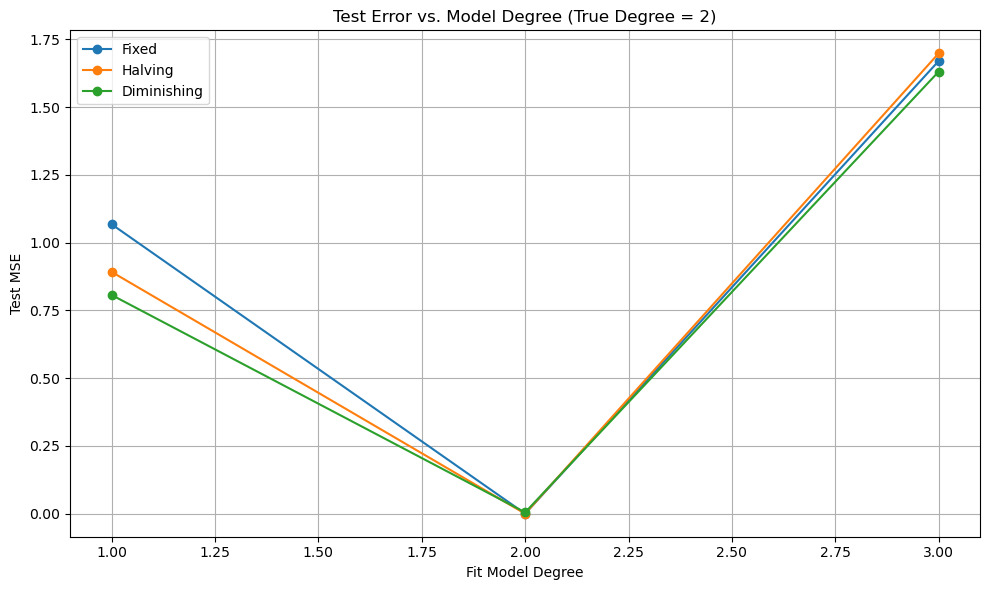

In [5]:
plt.figure(figsize=(10, 6))
for method in ["fixed", "halving", "diminishing"]:
    test_means = [test_losses[d][method] for d in degrees]  
    plt.plot(degrees, test_means, label=method.capitalize(), marker='o')
plt.xlabel("Fit Model Degree")
plt.ylabel("Test MSE")
plt.title(f"Test Error vs. Model Degree (True Degree = {true_degree})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Convergence Plots (Single Run)

Here, we show the distance to optimum, gradient norm, and suboptimality gap over 5000 iterations on one synthetic dataset for polynomial degree 3 for the correct model type.

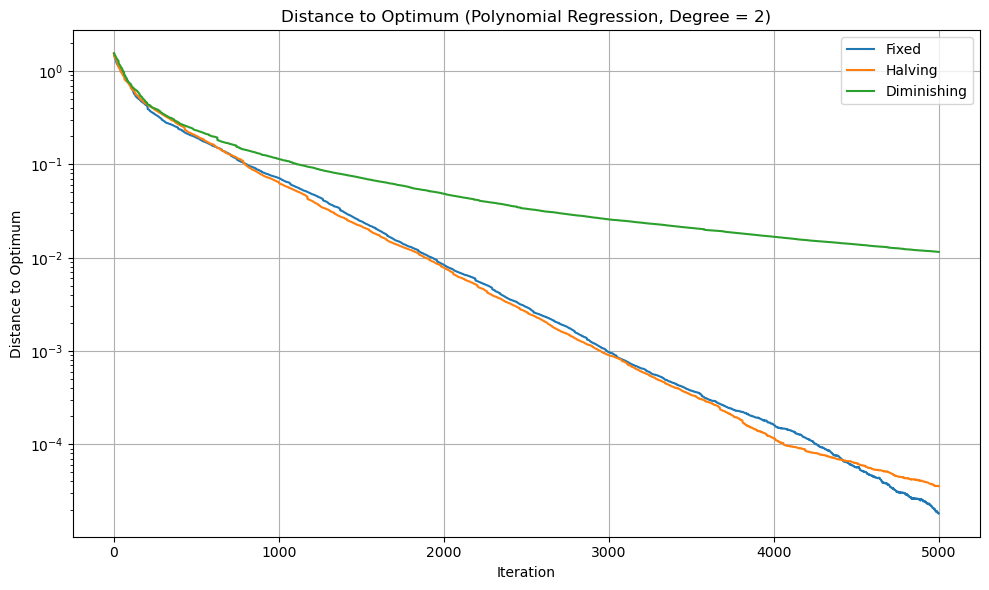

In [6]:
results_deg2 = results[2]  

plt.figure(figsize=(10, 6))
for method in results_deg2:
    plt.plot(results_deg2[method]["dist"], label=method.capitalize())
plt.xlabel("Iteration")
plt.ylabel("Distance to Optimum")
plt.yscale("log")
plt.title("Distance to Optimum (Polynomial Regression, Degree = 2)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

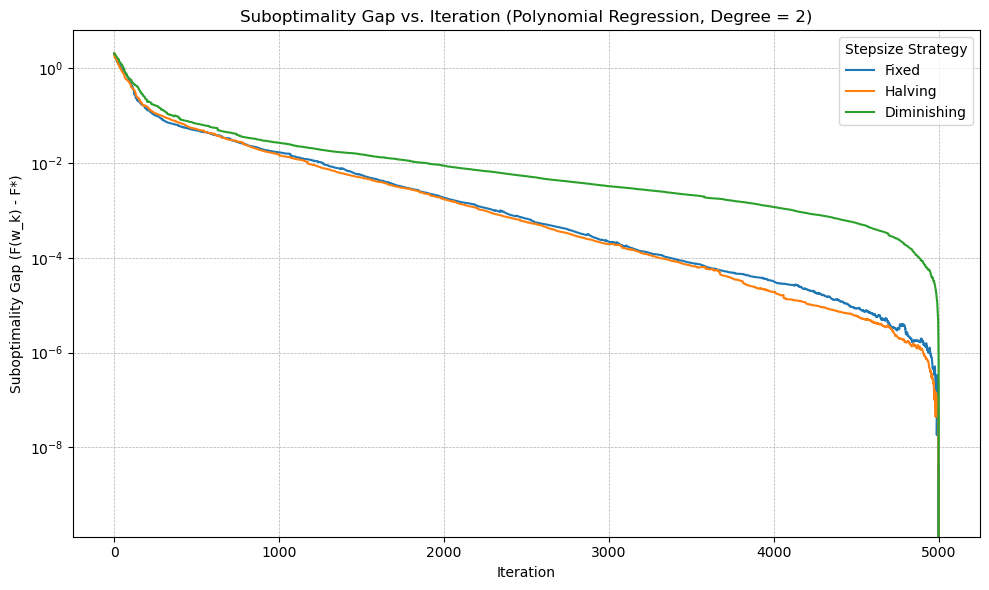

In [7]:
plt.figure(figsize=(10, 6))
plt.yscale("log")
for method in results_deg2:
    obj = results_deg2[method]["obj"]
    F_star = np.min(obj) 
    subopt_gap = obj - F_star
    plt.plot(subopt_gap, label=method.capitalize())
plt.xlabel("Iteration")
plt.ylabel("Suboptimality Gap (F(w_k) - F*)")
plt.title("Suboptimality Gap vs. Iteration (Polynomial Regression, Degree = 2)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend(title="Stepsize Strategy")
plt.tight_layout()
plt.show()

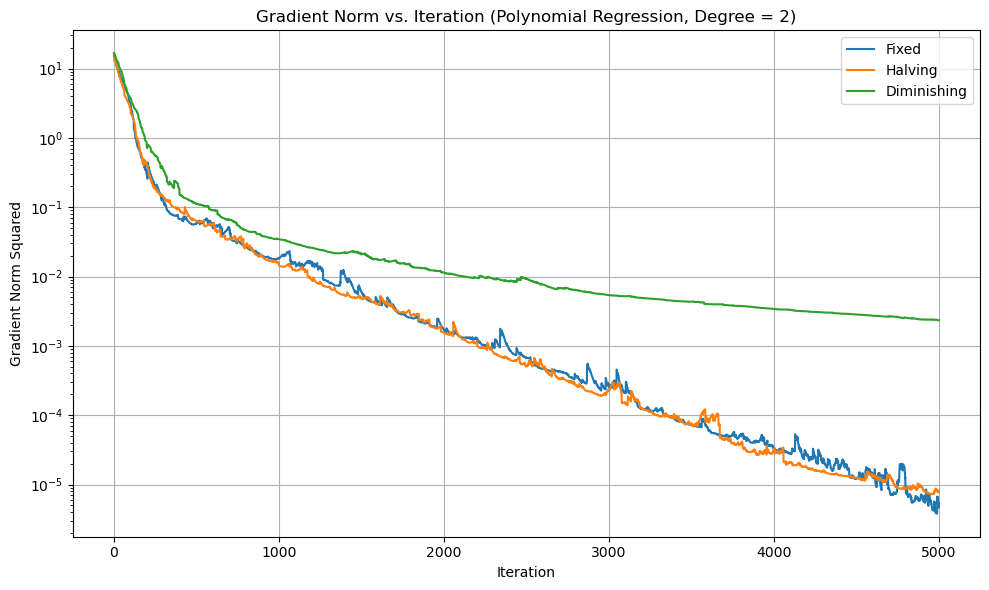

In [8]:
plt.figure(figsize=(10, 6))
for method in results_deg2:
    plt.plot(results_deg2[method]["grad"], label=method.capitalize())
plt.xlabel("Iteration")
plt.ylabel("Gradient Norm Squared")
plt.yscale("log")
plt.title("Gradient Norm vs. Iteration (Polynomial Regression, Degree = 2)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Theoretical Constants

The following constants were computed from the problem to derive the various stepsizes.

In [9]:
print("SGD Parameters for Fixed Polynomial Run (Degree = 2):")
print("="*60)
params_fixed = results[2]["fixed"]["params"]
scheduler_fixed = results[2]["fixed"]["scheduler"]
print(f"L (Lipschitz constant): {params_fixed['L']:.4f}")
print(f"c: {params_fixed['c']:.4f}")
print(f"M_G: {params_fixed['M_G']:.4f}")
print(f"M: {params_fixed['M']:.4f}")
print(f"M_V: {params_fixed['M_V']:.4f}")
print(f"mu: {params_fixed['mu']:.4f}")
print(f"mu_G: {params_fixed['mu_G']:.4f}")
print(f"Fixed stepsize (alpha): {scheduler_fixed.alpha:.6f}")
print("="*60)

print("True Parameters (used to generate synthetic data):")
print(f"A: {true_A}")
print(f"b: {true_b}")

print("\nLearned Parameters from Each Stepsize Strategy:")
print("-" * 60)
for method in results_deg2:
    w_method = results_deg2[method]["w"]
    print(f"{method.capitalize()} stepsize:")
    print(f"  Bias term (w_0): {w_method[0]:.4f}")
    print(f"  Weights (w_1,...): {w_method[1:]}")


SGD Parameters for Fixed Polynomial Run (Degree = 2):
L (Lipschitz constant): 4.3493
c: 0.4330
M_G: 96.7745
M: 0.0010
M_V: 95.7745
mu: 1.0000
mu_G: 1.0000
Fixed stepsize (alpha): 0.002376
True Parameters (used to generate synthetic data):
A: [0.1 0.2 0.3 0.4 0.5]
b: 1.0

Learned Parameters from Each Stepsize Strategy:
------------------------------------------------------------
Fixed stepsize:
  Bias term (w_0): 0.9960
  Weights (w_1,...): [0.10032443 0.19961481 0.30089761 0.40049456 0.50085927]
Halving stepsize:
  Bias term (w_0): 0.9945
  Weights (w_1,...): [0.1000322  0.20023371 0.30184343 0.40009686 0.50140343]
Diminishing stepsize:
  Bias term (w_0): 0.9000
  Weights (w_1,...): [0.09734379 0.19737842 0.32643486 0.39195563 0.52757415]
